In [1]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

### KungFuMaster env

In [2]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[60:-30, 15:],
                          color=False, n_frames=1)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation shape: (1, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


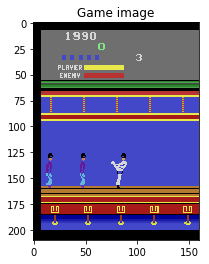

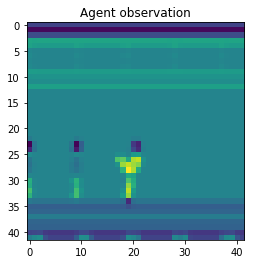

In [3]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation')
plt.imshow(s.reshape([42,42]))
plt.show()

### Simple agent for fully-observable MDP

Here's a code for an agent that only uses feedforward layers. Please read it carefully: you'll have to extend it later!

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class FeedforwardAgent(nn.Module):
    def __init__(self, obs_shape, n_actions):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()
        
        # Note: number of units/filters is arbitrary, you can and should change it at your will
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2))
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.flatten = Flatten()
        
        self.hid = nn.Linear(512, 128)
        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)
            
        
    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation (np.array), 
        returns next state and whatever it needs to learn (torch variables)
        """        
        nn = F.elu(self.conv0(obs_t))
        nn = F.elu(self.conv1(nn))
        nn = F.elu(self.conv2(nn))
        nn = self.flatten(nn)
        nn = F.elu(self.hid(nn))
        logits = self.logits(nn)
        state_value = self.state_value(nn)[:,0]
        
        # feedforward agent has no state
        new_state = []
        
        return new_state, (logits, state_value)
    
    def get_initial_state(self, batch_size):
        """
        Return a list of agent memory states at game start (Variables).
        Each state is a np array of shape [batch_size, ...]
        """
        # feedforward agent has no state
        return []
            
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()
    
    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is not Variable """
        obs_t = Variable(torch.FloatTensor(np.array(obs_t)))
        return self.forward(prev_state, obs_t)

In [ ]:
n_parallel_games = 5
gamma = 0.99

agent = FeedforwardAgent(obs_shape, n_actions)

In [55]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 Variable containing:

Columns 0 to 9 
-0.0325  0.0137  0.0580  0.0096 -0.1176 -0.0218 -0.0212  0.0147 -0.0366 -0.0625

Columns 10 to 13 
 0.0484  0.0207 -0.0204 -0.0532
[torch.FloatTensor of size 1x14]

state values:
 Variable containing:
1.00000e-02 *
 -3.0021
[torch.FloatTensor of size 1]



/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/jheuristic/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


### Let's play!
Let's build a function that measures agent's average reward.

In [ ]:
def evaluate(agent, env, n_games=1):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices



### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://s7.postimg.org/4y36s2b2z/env_pool.png)

In [ ]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [ ]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

In [ ]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ",rollout_obs.shape)

# Actor-critic

Here we define a loss function that uses rollout above to train

In [ ]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [ ]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = Variable(torch.FloatTensor(np.array(states)))   # shape: [batch_size, time, c, h, w]
    actions = Variable(torch.IntTensor(np.array(actions)))   # shape: [batch_size, time]
    rewards = Variable(torch.FloatTensor(np.array(rewards))) # shape: [batch_size, time]
    is_not_done = Variable(torch.FloatTensor(is_not_done.astype('float32')))  # shape: [batch_size, time]

    

    # predict logits, probas and log-probas using an agent. 
    memory = [m.detach() for m in prev_memory_states]
    
    logits = [] # append logit sequence here
    state_values = [] #append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        
        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array
        
        < YOUR CODE HERE >
        
        
    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    
    probas = <your code here>
    logprobas = <your code here>
        
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot,
                                      dim = -1)    
    # Policy gradient objective. 
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = [] # policy objective as in the formula for J_hat
    
    # Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    TD_loss = []
    
    for t in range(rewards.shape[1] - 1):
        
        # compute TD_loss and J_hat for moment  
        J_hat.append(<YOUR CODE>)
        TD_loss.append(<YOUR_CODE>)
        
    J_hat = torch.cat(J_hat).mean()
    TD_loss = TD_loss(TD_loss).mean()
    
    #regularize with entropy
    entropy = <compute mean entropy of probas. Don't forget the sign!>
    
    loss = - J_hat - 0.01 * entropy_reg + TD_loss
    
    # Gradient descent step
    < your code >
    
    return loss.data.numpy()

In [ ]:
# let's test it
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)

# Train 

just run train step and see if agent learns any better

In [ ]:
from IPython.display import clear_output
from tqdm import trange
from pandas import ewma
rewards_history = []

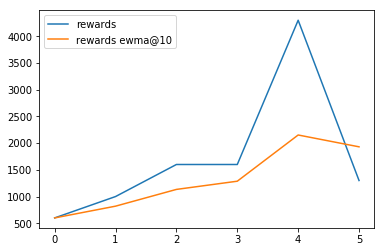

  6%|▌         | 584/10000 [02:24<38:50,  4.04it/s]

In [ ]:
for i in trange(5000):  
    
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)
    train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)    
    
    if i % 100 == 0: 
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), label='rewards ewma@10')
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break

### "Final" evaluation

In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward": np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices



### POMDP setting

The atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this.

__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [ ]:
class SimpleRecurrentAgent:
    def __init__(self, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        <YOUR CODE>
        
    def forward(self, prev_state, obs_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        <YOUR CODE>
        
        # YOUR CODE: apply recurrent neural net for one step here.
        # See docs on self.rnn0(...)
        # the recurrent cell should take the last feedforward dense layer as input
        raise NotImplementedError("Please implement rnn step")
        
        new_state = <YOUR CODE>
        
        return new_state, (logits, state_value)
    
    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return <YOUR CODE>

    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()
    
    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is not Variable """
        obs_t = Variable(torch.FloatTensor(np.array(obs_t)))
        return self.forward(prev_state, obs_t)

In [52]:
agent = SimpleRecurrentAgent(obs_shape, n_actions)

### Now let's train it!

In [ ]:
### A whole lot of your code here: train the new agent with GRU memory.
# - create pool
# - write loss functions and training op
# - train
# You can reuse most of the code with zero to few changes

```

```
```

```
```

```
```

```
```

```
```

```
```

```
```

```


### Homework assignment is TBA